# Etap 2: Professional Data Visualization

Professional, individual visualizations of the Airbnb data for comprehensive analysis:
- Clean, separate plots for better readability
- High-quality figures suitable for reports
- Individual charts focusing on specific insights
- No cramped subplot arrangements

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # Added for interactive plots
import warnings
warnings.filterwarnings('ignore')

# Set professional plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

print("Professional visualization setup complete")

Professional visualization setup complete


## Data Loading

In [21]:
# Load processed datasets
processed_data_dir = '../data/processed/etap2/'

print("Loading datasets...")
listings_df = pd.read_pickle(processed_data_dir + 'listings_e2_df.pkl')
calendar_df = pd.read_pickle(processed_data_dir + 'calendar_e2_df.pkl')
reviews_df = pd.read_pickle(processed_data_dir + 'reviews_e2_df.pkl')

print(f"Listings: {listings_df.shape}")
print(f"Calendar: {calendar_df.shape}")
print(f"Reviews: {reviews_df.shape}")

# Load revenue analysis if available
try:
    reliable_listings = pd.read_pickle(processed_data_dir + 'analysis/reliable_listings.pkl')
    print(f"Reliable listings: {reliable_listings.shape}")
    has_reliable_data = True
except FileNotFoundError:
    print("Reliable listings data not found")
    has_reliable_data = False

Loading datasets...
Listings: (47572, 75)
Calendar: (17363102, 5)
Reviews: (953651, 7)
Reliable listings: (95142, 14)
Listings: (47572, 75)
Calendar: (17363102, 5)
Reviews: (953651, 7)
Reliable listings: (95142, 14)


## Missing Value Analysis

In [22]:
# Calculate missing values for key features
key_features = [
    'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates',
    'bedrooms', 'beds', 'bathrooms_text', 'price', 'minimum_nights',
    'availability_365', 'number_of_reviews', 'review_scores_rating',
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
    'review_scores_communication', 'review_scores_location', 'review_scores_value',
    'host_is_superhost', 'host_identity_verified', 'instant_bookable',
    'latitude', 'longitude'
]

available_features = [f for f in key_features if f in listings_df.columns]

missing_data = []
for feature in available_features:
    missing_count = listings_df[feature].isna().sum()
    missing_pct = (missing_count / len(listings_df)) * 100
    missing_data.append({
        'feature': feature,
        'missing_count': missing_count,
        'missing_percentage': missing_pct
    })

missing_df = pd.DataFrame(missing_data).sort_values('missing_percentage', ascending=False)
print("Missing value summary:")
print(missing_df.head(10))

Missing value summary:
                        feature  missing_count  missing_percentage
5                          beds          16236           34.129320
7                         price          16189           34.030522
16       review_scores_location          12272           25.796687
17          review_scores_value          12271           25.794585
14        review_scores_checkin          12271           25.794585
15  review_scores_communication          12260           25.771462
12       review_scores_accuracy          12256           25.763054
13    review_scores_cleanliness          12253           25.756748
11         review_scores_rating          12247           25.744135
4                      bedrooms           6213           13.060203


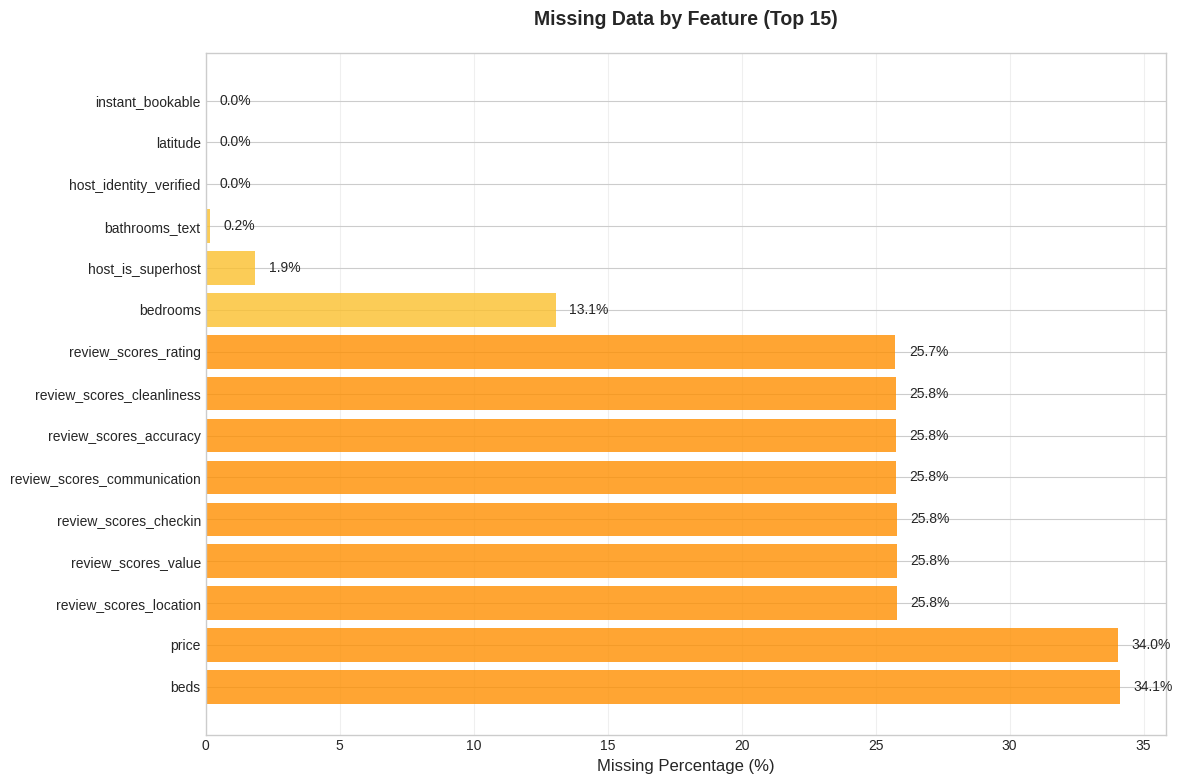

In [23]:
# Chart 1: Missing Data Percentages
plt.figure(figsize=(12, 8))
top_missing = missing_df.head(15)

# Create color map based on severity
colors = []
for pct in top_missing['missing_percentage']:
    if pct > 50:
        colors.append('#D32F2F')  # Red
    elif pct > 20:
        colors.append('#FF8F00')  # Orange
    else:
        colors.append('#FBC02D')  # Yellow

bars = plt.barh(range(len(top_missing)), top_missing['missing_percentage'], color=colors, alpha=0.8)
plt.yticks(range(len(top_missing)), top_missing['feature'])
plt.xlabel('Missing Percentage (%)')
plt.title('Missing Data by Feature (Top 15)', fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)

# Add percentage labels on bars
for i, (idx, row) in enumerate(top_missing.iterrows()):
    plt.text(row['missing_percentage'] + 0.5, i, f"{row['missing_percentage']:.1f}%",
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

Features selected for missing value correlation: ['neighbourhood_cleansed', 'latitude', 'longitude', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'number_of_reviews']
Shape of missing_matrix: (47572, 11)
Shape of correlation_matrix: (11, 11)


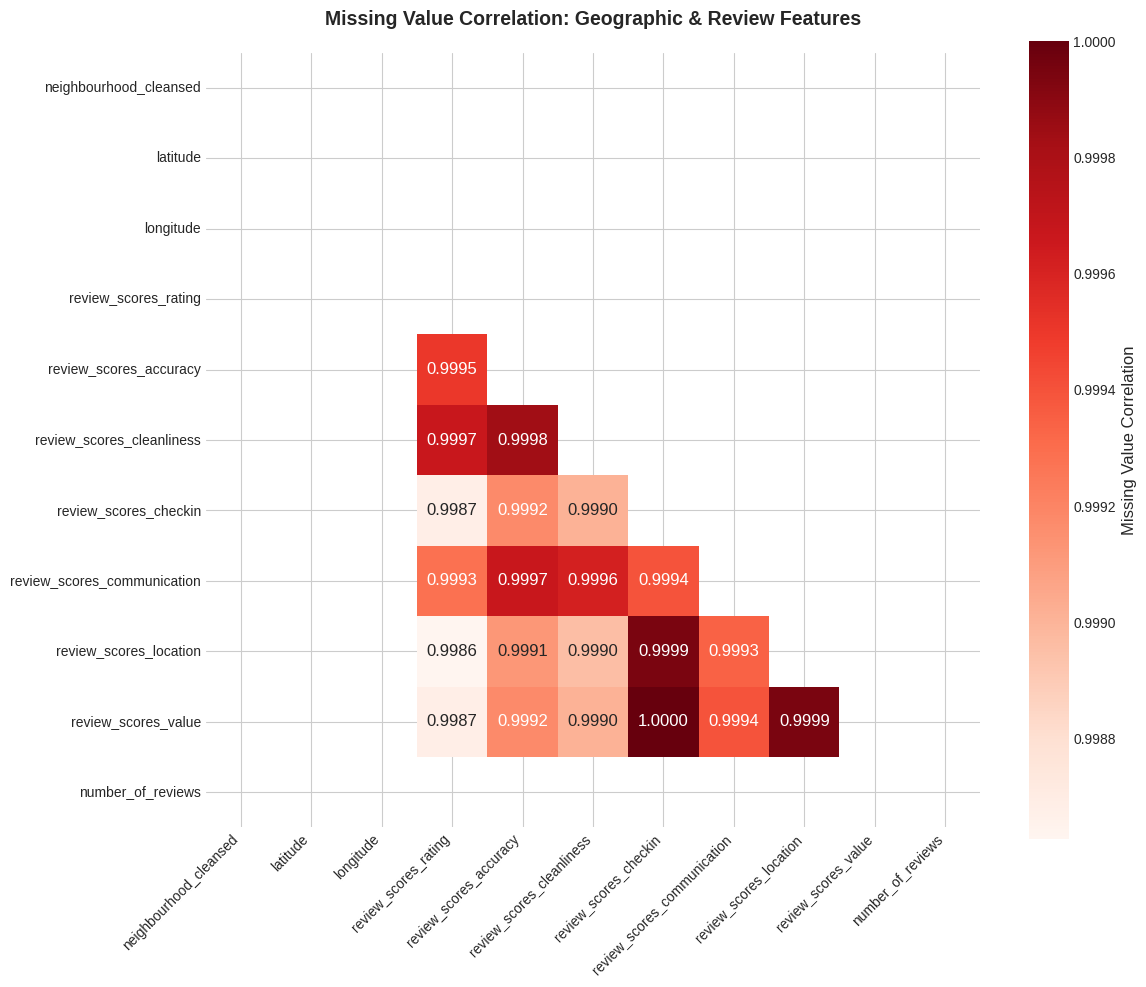

In [24]:
# Chart 2: Missing Value Correlation for Geographic and Review Features
geo_review_features = ['neighbourhood_cleansed', 'latitude', 'longitude',
                      'review_scores_rating', 'review_scores_accuracy',
                      'review_scores_cleanliness', 'review_scores_checkin',
                      'review_scores_communication', 'review_scores_location',
                      'review_scores_value', 'number_of_reviews']
geo_review_available = [f for f in geo_review_features if f in listings_df.columns]

if geo_review_available:
    print(f"Features selected for missing value correlation: {geo_review_available}")
    plt.figure(figsize=(12, 10))
    missing_matrix = listings_df[geo_review_available].isna()
    print(f"Shape of missing_matrix: {missing_matrix.shape}")
    correlation_matrix = missing_matrix.corr()
    print(f"Shape of correlation_matrix: {correlation_matrix.shape}")

    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".4f", cmap='Reds',
                square=True, cbar_kws={'label': 'Missing Value Correlation'})
    plt.title('Missing Value Correlation: Geographic & Review Features', fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## Neighborhood Analysis

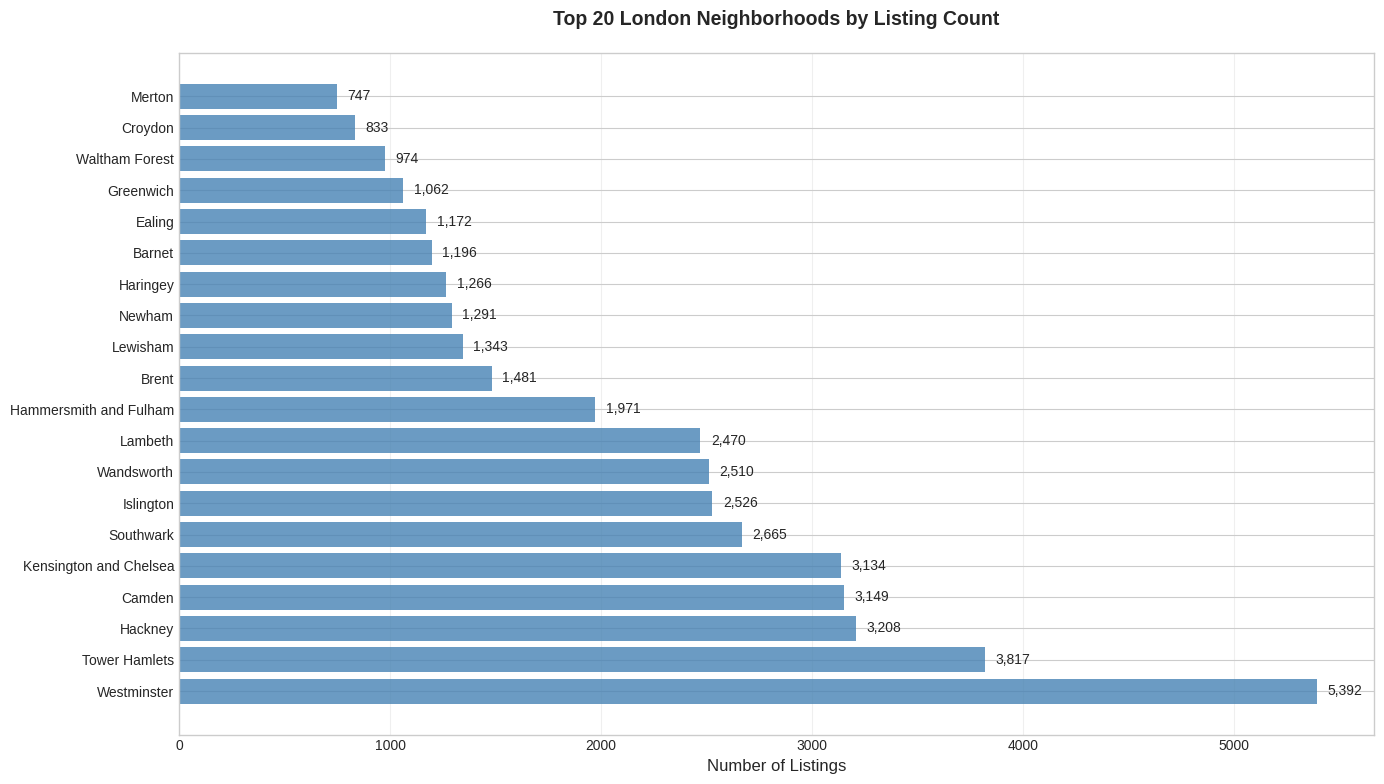

In [25]:
# Chart 3: Top Neighborhoods by Listing Count
if 'neighbourhood_cleansed' in listings_df.columns:
    neighbourhood_counts = listings_df['neighbourhood_cleansed'].value_counts()

    plt.figure(figsize=(14, 8))
    top_20_neighbourhoods = neighbourhood_counts.head(20)
    bars = plt.barh(range(len(top_20_neighbourhoods)), top_20_neighbourhoods.values,
                   color='steelblue', alpha=0.8)
    plt.yticks(range(len(top_20_neighbourhoods)), top_20_neighbourhoods.index)
    plt.xlabel('Number of Listings')
    plt.title('Top 20 London Neighborhoods by Listing Count', fontweight='bold', pad=20)
    plt.grid(axis='x', alpha=0.3)

    # Add value labels
    for i, count in enumerate(top_20_neighbourhoods.values):
        plt.text(count + 50, i, f'{count:,}', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

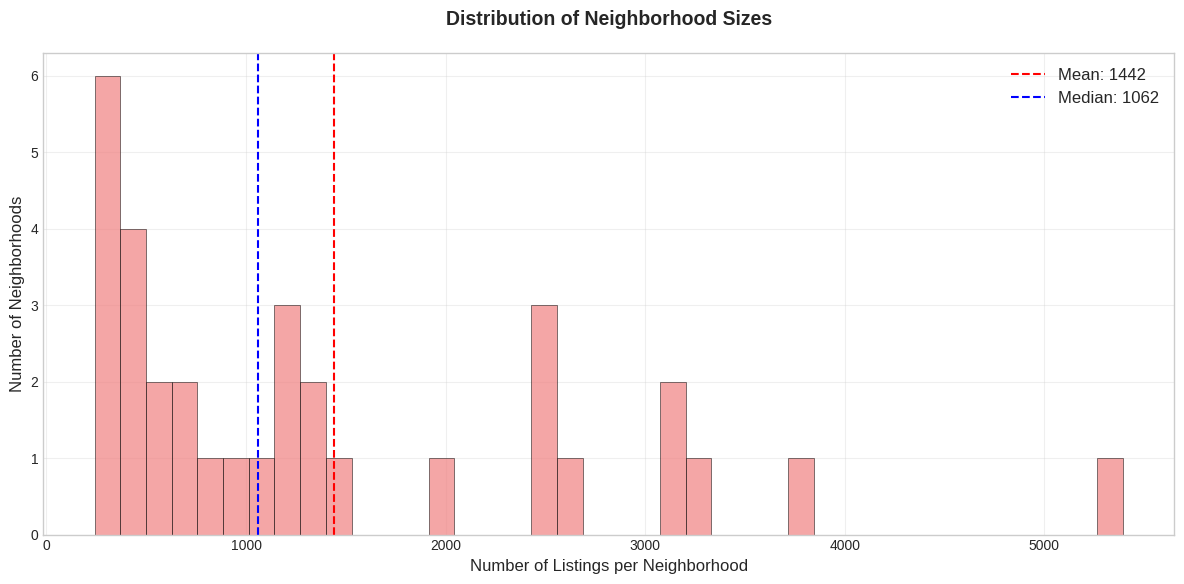

In [26]:
# Chart 4: Distribution of Neighborhood Sizes
if 'neighbourhood_cleansed' in listings_df.columns:
    plt.figure(figsize=(12, 6))
    neighbourhood_counts = listings_df['neighbourhood_cleansed'].value_counts()

    plt.hist(neighbourhood_counts.values, bins=40, alpha=0.7, color='lightcoral',
             edgecolor='black', linewidth=0.5)
    plt.xlabel('Number of Listings per Neighborhood')
    plt.ylabel('Number of Neighborhoods')
    plt.title('Distribution of Neighborhood Sizes', fontweight='bold', pad=20)
    plt.grid(alpha=0.3)

    # Add statistics
    mean_size = neighbourhood_counts.mean()
    median_size = neighbourhood_counts.median()
    plt.axvline(mean_size, color='red', linestyle='--', label=f'Mean: {mean_size:.0f}')
    plt.axvline(median_size, color='blue', linestyle='--', label=f'Median: {median_size:.0f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Geographic Distribution

In [ ]:
# Chart 5: Interactive London Listings Geographic Distribution
if 'latitude' in listings_df.columns and 'longitude' in listings_df.columns:
    # Prepare data for Plotly (handle potential NaNs for color/hover)
    plot_df = listings_df[['latitude', 'longitude', 'room_type', 'price', 'neighbourhood_cleansed']].copy()
    plot_df.dropna(subset=['latitude', 'longitude'], inplace=True)
    plot_df['price_cleaned'] = plot_df['price'].replace({r'\$|,': ''}, regex=True).astype(float)
    plot_df['room_type'] = plot_df['room_type'].fillna('Unknown')
    plot_df['neighbourhood_cleansed'] = plot_df['neighbourhood_cleansed'].fillna('Unknown')

    # Take a smaller sample for better performance in interactive plots
    sample_size = min(20000, len(plot_df)) # Sample 20,000 or fewer points
    sample_df = plot_df.sample(n=sample_size, random_state=42)

    fig = px.scatter_mapbox(sample_df,
                            lat="latitude",
                            lon="longitude",
                            color="room_type",
                            size="price_cleaned", # Optionally size by price
                            hover_name="neighbourhood_cleansed", # Show neighborhood on hover
                            hover_data={"latitude": False, "longitude": False, "room_type": True, "price_cleaned": ":.2f"},
                            color_discrete_sequence=px.colors.qualitative.Plotly,
                            zoom=10,
                            height=700,
                            title=f'Interactive Geographic Distribution of London Airbnb Listings (Sampled n={sample_size:,})')

    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
    fig.show()
else:
    print("Latitude or Longitude data not available in listings_df.")

SyntaxError: unexpected character after line continuation character (3536359073.py, line 6)

## Property Features

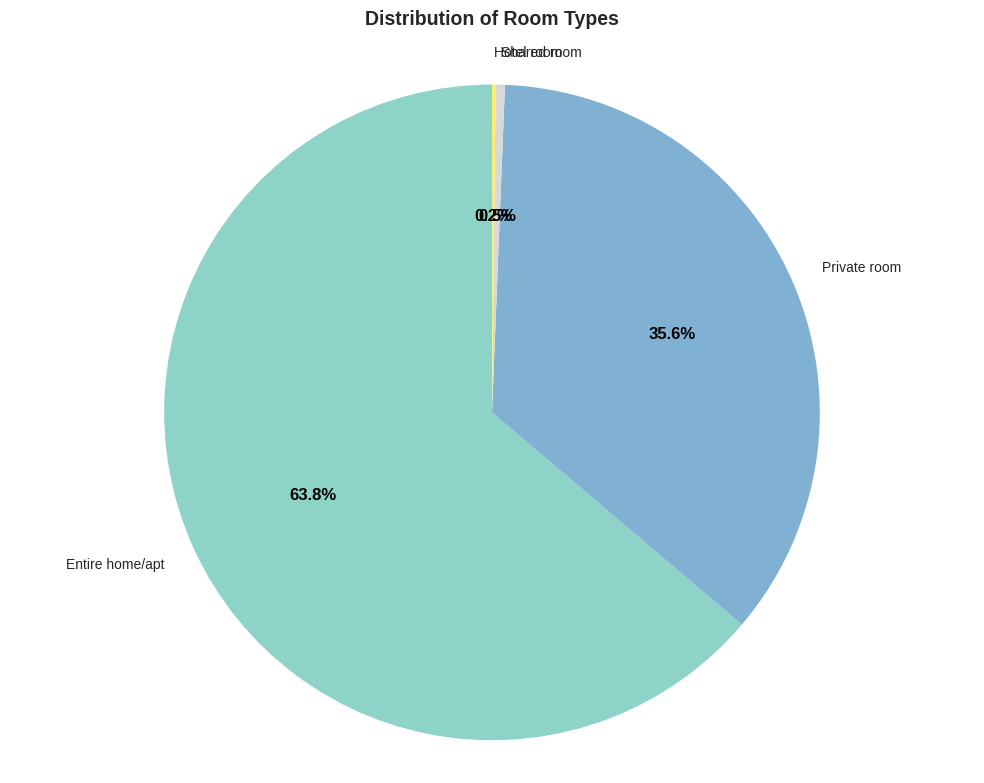

In [ ]:
# Chart 6: Room Type Distribution
if 'room_type' in listings_df.columns:
    plt.figure(figsize=(10, 8))
    room_counts = listings_df['room_type'].value_counts()

    colors = plt.cm.Set3(np.linspace(0, 1, len(room_counts)))
    wedges, texts, autotexts = plt.pie(room_counts.values, labels=room_counts.index,
                                      autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('Distribution of Room Types', fontweight='bold', pad=20)

    # Enhance text
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')

    plt.axis('equal')
    plt.tight_layout()
    plt.show()

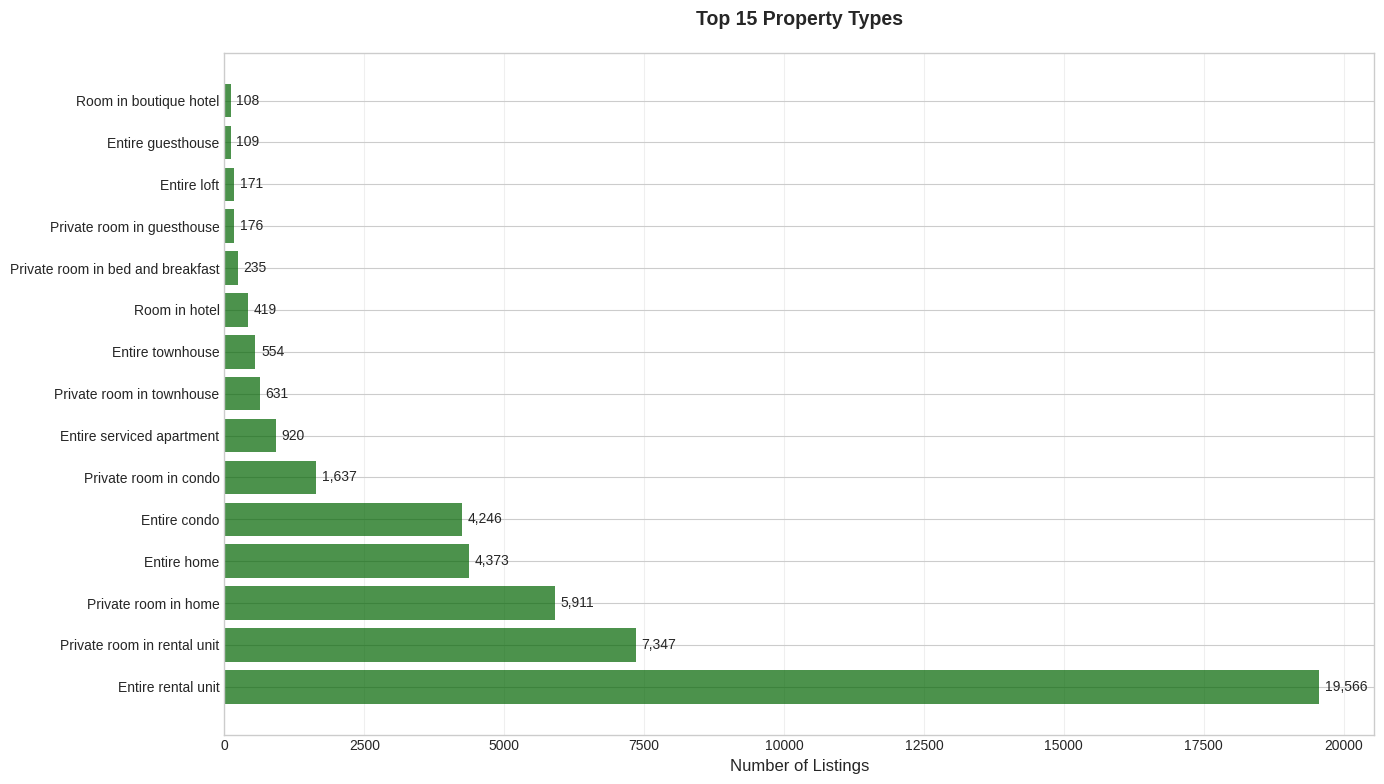

In [ ]:
# Chart 7: Property Type Distribution (Top 15)
if 'property_type' in listings_df.columns:
    plt.figure(figsize=(14, 8))
    property_counts = listings_df['property_type'].value_counts().head(15)

    bars = plt.barh(range(len(property_counts)), property_counts.values,
                   color='darkgreen', alpha=0.7)
    plt.yticks(range(len(property_counts)), property_counts.index)
    plt.xlabel('Number of Listings')
    plt.title('Top 15 Property Types', fontweight='bold', pad=20)
    plt.grid(axis='x', alpha=0.3)

    # Add value labels
    for i, count in enumerate(property_counts.values):
        plt.text(count + 100, i, f'{count:,}', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

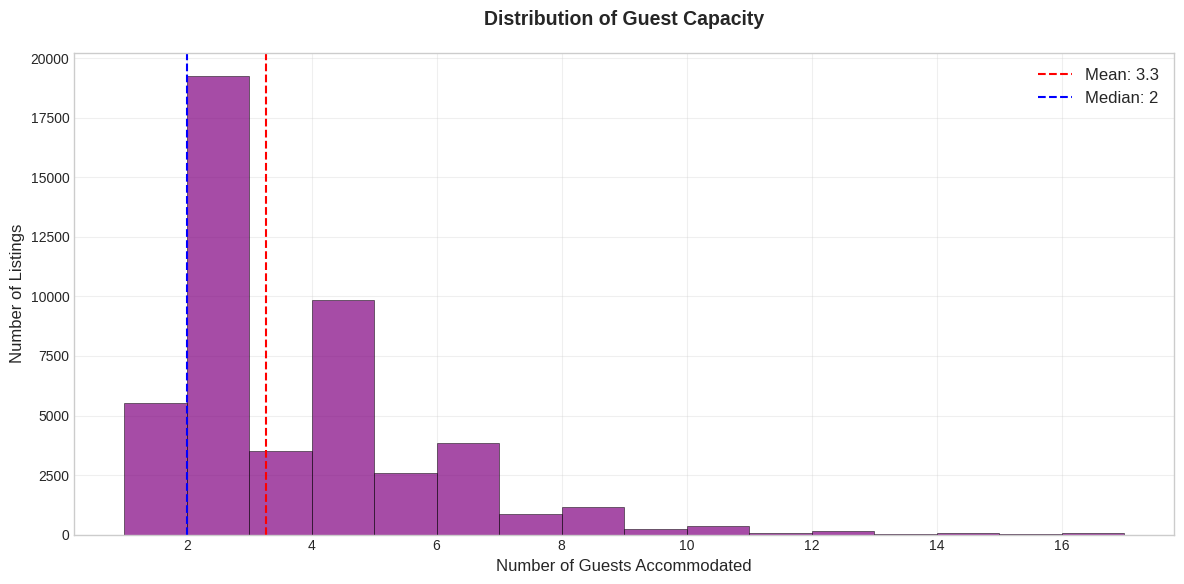

In [ ]:
# Chart 8: Accommodates Distribution
if 'accommodates' in listings_df.columns:
    plt.figure(figsize=(12, 6))
    accommodates_data = pd.to_numeric(listings_df['accommodates'], errors='coerce').dropna()

    plt.hist(accommodates_data, bins=range(1, int(accommodates_data.max()) + 2),
             alpha=0.7, color='purple', edgecolor='black', linewidth=0.5)
    plt.xlabel('Number of Guests Accommodated')
    plt.ylabel('Number of Listings')
    plt.title('Distribution of Guest Capacity', fontweight='bold', pad=20)
    plt.grid(alpha=0.3)

    # Add statistics
    mean_acc = accommodates_data.mean()
    median_acc = accommodates_data.median()
    plt.axvline(mean_acc, color='red', linestyle='--', label=f'Mean: {mean_acc:.1f}')
    plt.axvline(median_acc, color='blue', linestyle='--', label=f'Median: {median_acc:.0f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Review Scores Analysis

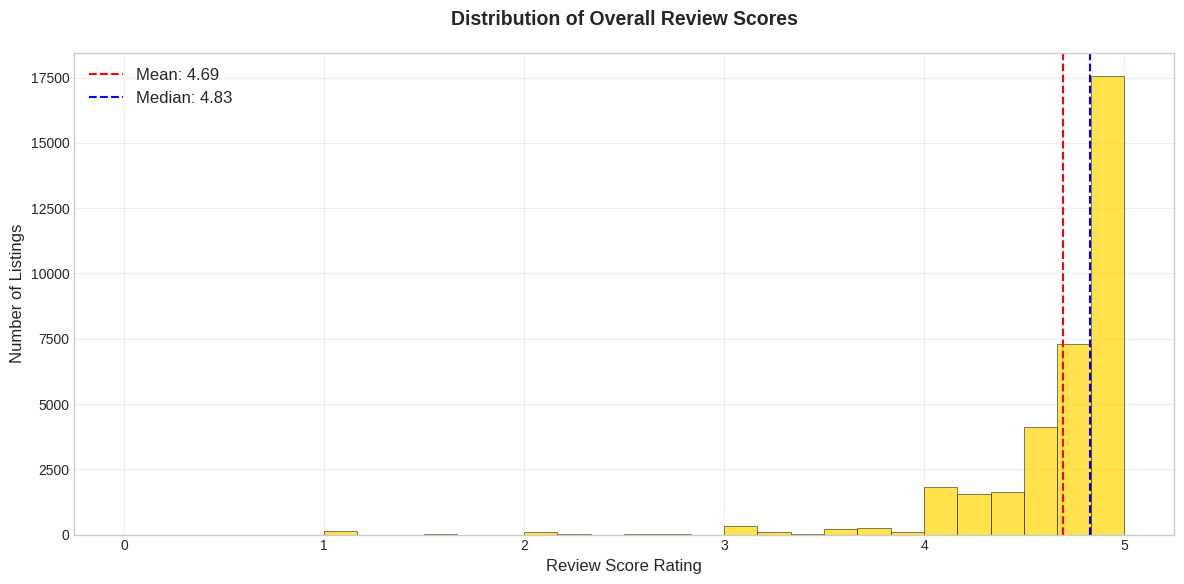

In [ ]:
# Chart 9: Overall Review Scores Distribution
if 'review_scores_rating' in listings_df.columns:
    plt.figure(figsize=(12, 6))
    review_scores = pd.to_numeric(listings_df['review_scores_rating'], errors='coerce').dropna()

    plt.hist(review_scores, bins=30, alpha=0.7, color='gold', edgecolor='black', linewidth=0.5)
    plt.xlabel('Review Score Rating')
    plt.ylabel('Number of Listings')
    plt.title('Distribution of Overall Review Scores', fontweight='bold', pad=20)
    plt.grid(alpha=0.3)

    # Add statistics
    mean_score = review_scores.mean()
    median_score = review_scores.median()
    plt.axvline(mean_score, color='red', linestyle='--', label=f'Mean: {mean_score:.2f}')
    plt.axvline(median_score, color='blue', linestyle='--', label=f'Median: {median_score:.2f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

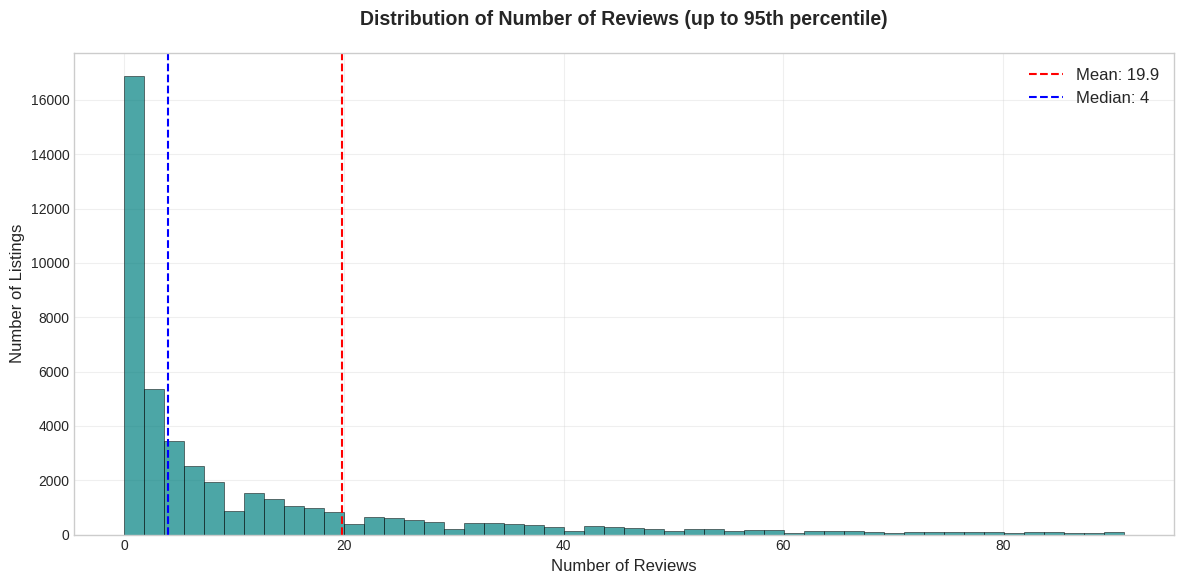

In [ ]:
# Chart 10: Number of Reviews Distribution
if 'number_of_reviews' in listings_df.columns:
    plt.figure(figsize=(12, 6))
    review_counts = pd.to_numeric(listings_df['number_of_reviews'], errors='coerce').dropna()

    # Focus on 95th percentile to avoid extreme outliers
    upper_limit = review_counts.quantile(0.95)
    filtered_reviews = review_counts[review_counts <= upper_limit]

    plt.hist(filtered_reviews, bins=50, alpha=0.7, color='teal', edgecolor='black', linewidth=0.5)
    plt.xlabel('Number of Reviews')
    plt.ylabel('Number of Listings')
    plt.title('Distribution of Number of Reviews (up to 95th percentile)', fontweight='bold', pad=20)
    plt.grid(alpha=0.3)

    # Add statistics
    mean_reviews = review_counts.mean()
    median_reviews = review_counts.median()
    plt.axvline(mean_reviews, color='red', linestyle='--', label=f'Mean: {mean_reviews:.1f}')
    plt.axvline(median_reviews, color='blue', linestyle='--', label=f'Median: {median_reviews:.0f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Calendar and Price Analysis

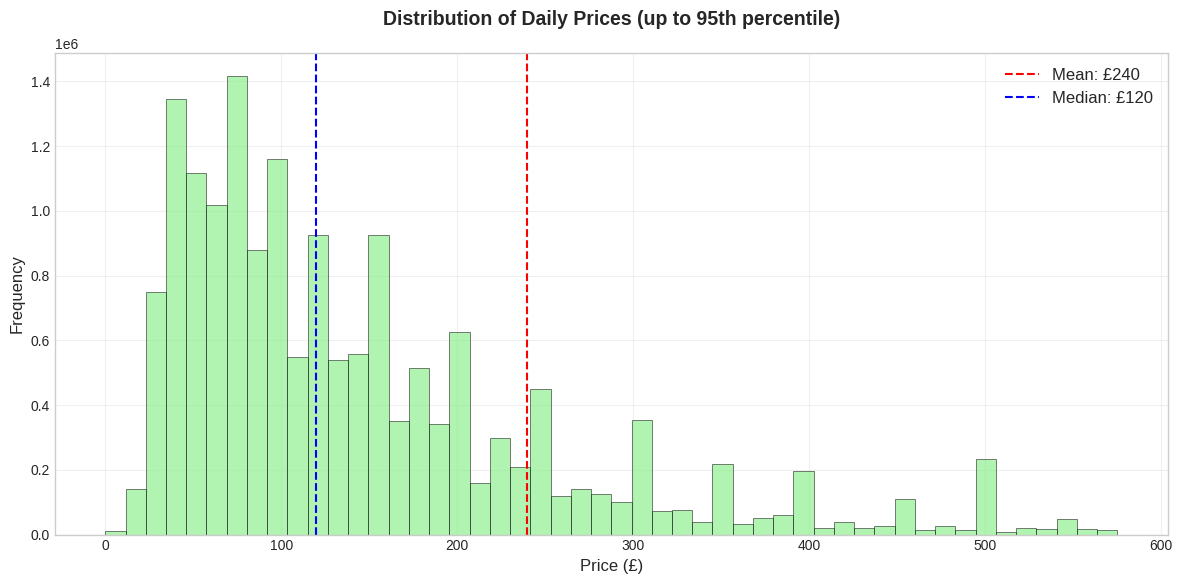

In [ ]:
# Chart 11: Price Distribution from Calendar Data
if 'price_cleaned' in calendar_df.columns:
    plt.figure(figsize=(12, 6))
    valid_prices = calendar_df['price_cleaned'].dropna()

    # Focus on reasonable price range (up to 95th percentile)
    upper_limit = valid_prices.quantile(0.95)
    filtered_prices = valid_prices[valid_prices <= upper_limit]

    plt.hist(filtered_prices, bins=50, alpha=0.7, color='lightgreen', edgecolor='black', linewidth=0.5)
    plt.xlabel('Price (£)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Daily Prices (up to 95th percentile)', fontweight='bold', pad=20)
    plt.grid(alpha=0.3)

    # Add statistics
    mean_price = valid_prices.mean()
    median_price = valid_prices.median()
    plt.axvline(mean_price, color='red', linestyle='--', label=f'Mean: £{mean_price:.0f}')
    plt.axvline(median_price, color='blue', linestyle='--', label=f'Median: £{median_price:.0f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

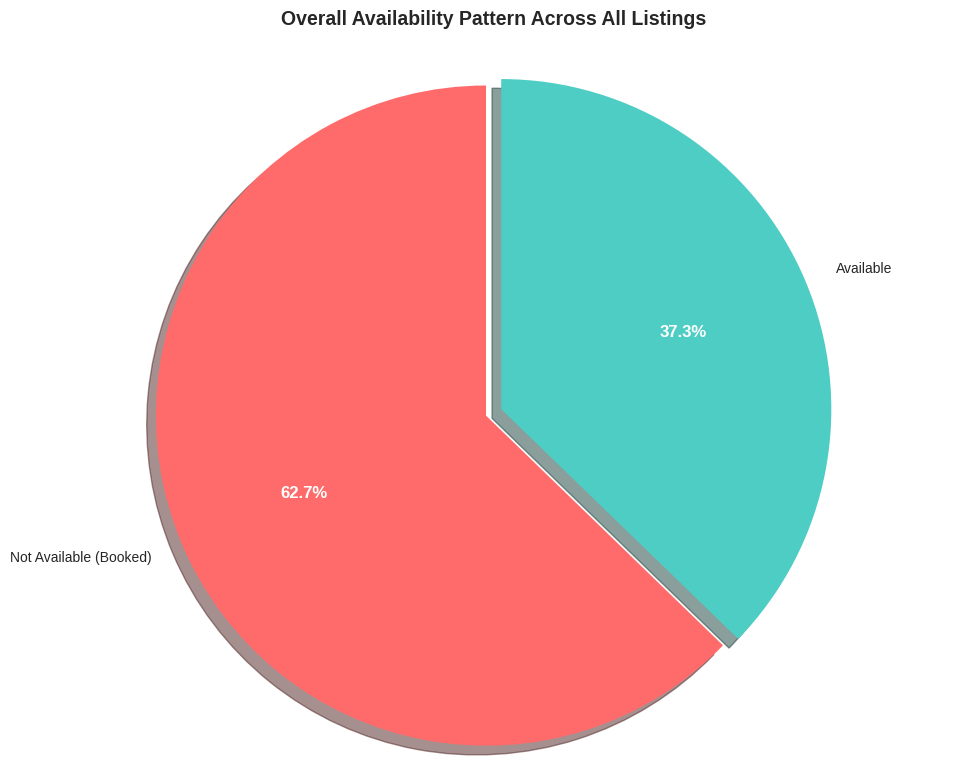

In [ ]:
# Chart 12: Availability Pattern
if 'available' in calendar_df.columns:
    plt.figure(figsize=(10, 8))
    availability_counts = calendar_df['available'].value_counts()

    labels = ['Not Available (Booked)', 'Available']
    colors = ['#FF6B6B', '#4ECDC4']
    explode = (0.05, 0)  # Slightly separate the "booked" slice

    wedges, texts, autotexts = plt.pie(availability_counts.values, labels=labels,
                                      autopct='%1.1f%%', colors=colors, explode=explode,
                                      startangle=90, shadow=True)
    plt.title('Overall Availability Pattern Across All Listings', fontweight='bold', pad=20)

    # Enhance text
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(12)

    plt.axis('equal')
    plt.tight_layout()
    plt.show()

## Revenue Analysis (if available)


=== DETAILED REVENUE DATA ANALYSIS ===
Total records: 95,142
Unique values: 47,666
Data type: float64

BASIC STATISTICS:
Min: £0.00
Max: £29,200,000.00
Mean: £48,463.14
Median: £22,995.00
Std Dev: £210,392.76

RANGE ANALYSIS (Key for binning):
Total range: £29,200,000.00
Range / 50 bins = £584,000.00 per bin
Range / 20 bins = £1,460,000.00 per bin

OUTLIER ANALYSIS:
Q1 (25th percentile): £9,591.53
Q3 (75th percentile): £44,889.98
IQR: £35,298.45
Lower fence (Q1 - 1.5*IQR): £-43,356.14
Upper fence (Q3 + 1.5*IQR): £97,837.65
Lower outliers: 0 (0.00%)
Upper outliers: 6,545 (6.88%)
Highest outlier: £29,200,000.00
Outlier impact on range: 99.7% of total range

PERCENTILE ANALYSIS:
50.0th percentile: £    22,995
75.0th percentile: £    44,890
90.0th percentile: £    78,803
95.0th percentile: £   116,800
99.0th percentile: £   365,000
99.5th percentile: £ 1,049,663
99.9th percentile: £ 3,519,069

BIN SIZE ANALYSIS:
Full range (50 bins): Bin width = £584,000
95th percentile range (50 bins): B

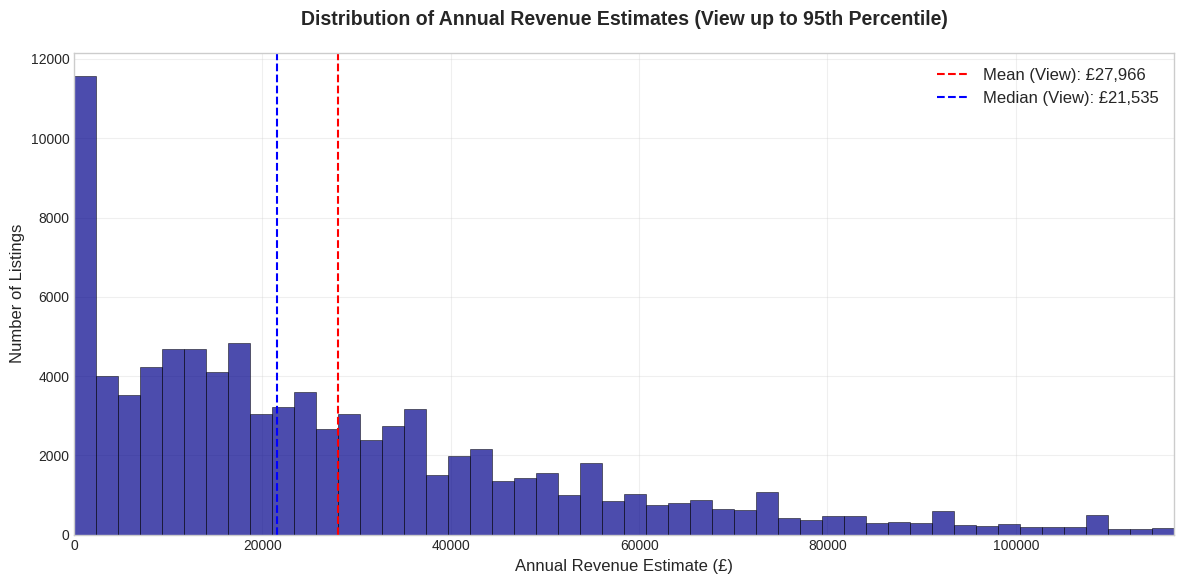


=== SUMMARY ===
Your assumption appears to be: True (bin width ≥ £1,000 indicates large bins)
Bin width improvement with outlier removal: 584,000 → 2,336 (£)
This represents a 99.6% improvement in resolution


In [ ]:
# Chart 13: Annual Revenue Estimate Distribution (if available)
if has_reliable_data and 'annual_revenue_estimate' in reliable_listings.columns:
    plt.figure(figsize=(12, 6))
    revenue_data = reliable_listings['annual_revenue_estimate'].dropna()

    # COMPREHENSIVE LOGGING TO DIAGNOSE BINNING ISSUES
    print("\n=== DETAILED REVENUE DATA ANALYSIS ===")
    print(f"Total records: {len(revenue_data):,}")
    print(f"Unique values: {revenue_data.nunique():,}")
    print(f"Data type: {revenue_data.dtype}")

    # Basic statistics
    print(f"\nBASIC STATISTICS:")
    print(f"Min: £{revenue_data.min():,.2f}")
    print(f"Max: £{revenue_data.max():,.2f}")
    print(f"Mean: £{revenue_data.mean():,.2f}")
    print(f"Median: £{revenue_data.median():,.2f}")
    print(f"Std Dev: £{revenue_data.std():,.2f}")

    # Range analysis - THIS IS KEY FOR YOUR ASSUMPTION
    data_range = revenue_data.max() - revenue_data.min()
    print(f"\nRANGE ANALYSIS (Key for binning):")
    print(f"Total range: £{data_range:,.2f}")
    print(f"Range / 50 bins = £{data_range/50:,.2f} per bin")
    print(f"Range / 20 bins = £{data_range/20:,.2f} per bin")

    # Outlier analysis
    q1 = revenue_data.quantile(0.25)
    q3 = revenue_data.quantile(0.75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr

    outliers_lower = revenue_data[revenue_data < lower_fence]
    outliers_upper = revenue_data[revenue_data > upper_fence]

    print(f"\nOUTLIER ANALYSIS:")
    print(f"Q1 (25th percentile): £{q1:,.2f}")
    print(f"Q3 (75th percentile): £{q3:,.2f}")
    print(f"IQR: £{iqr:,.2f}")
    print(f"Lower fence (Q1 - 1.5*IQR): £{lower_fence:,.2f}")
    print(f"Upper fence (Q3 + 1.5*IQR): £{upper_fence:,.2f}")
    print(f"Lower outliers: {len(outliers_lower):,} ({len(outliers_lower)/len(revenue_data)*100:.2f}%)")
    print(f"Upper outliers: {len(outliers_upper):,} ({len(outliers_upper)/len(revenue_data)*100:.2f}%)")

    if len(outliers_upper) > 0:
        print(f"Highest outlier: £{outliers_upper.max():,.2f}")
        print(f"Outlier impact on range: {(outliers_upper.max() - upper_fence) / data_range * 100:.1f}% of total range")

    # Percentile analysis
    print(f"\nPERCENTILE ANALYSIS:")
    percentiles = [50, 75, 90, 95, 99, 99.5, 99.9]
    for p in percentiles:
        val = revenue_data.quantile(p/100)
        print(f"{p:4.1f}th percentile: £{val:>10,.0f}")

    # Bin size analysis for different approaches
    print(f"\nBIN SIZE ANALYSIS:")

    # Full range binning
    hist_counts_full, bin_edges_full = np.histogram(revenue_data, bins=50)
    bin_width_full = bin_edges_full[1] - bin_edges_full[0]
    print(f"Full range (50 bins): Bin width = £{bin_width_full:,.0f}")

    # 95th percentile range binning
    upper_limit_95 = revenue_data.quantile(0.95)
    filtered_data_95 = revenue_data[revenue_data <= upper_limit_95]
    hist_counts_95, bin_edges_95 = np.histogram(filtered_data_95, bins=50)
    bin_width_95 = bin_edges_95[1] - bin_edges_95[0]
    print(f"95th percentile range (50 bins): Bin width = £{bin_width_95:,.0f}")
    print(f"Bin width reduction: {((bin_width_full - bin_width_95) / bin_width_full) * 100:.1f}%")

    # IQR range binning
    iqr_data = revenue_data[(revenue_data >= q1) & (revenue_data <= q3)]
    if len(iqr_data) > 0:
        hist_counts_iqr, bin_edges_iqr = np.histogram(iqr_data, bins=30)
        bin_width_iqr = bin_edges_iqr[1] - bin_edges_iqr[0]
        print(f"IQR range (30 bins): Bin width = £{bin_width_iqr:,.0f}")

    # Data concentration analysis
    print(f"\nDATA CONCENTRATION:")
    data_in_95th = len(revenue_data[revenue_data <= upper_limit_95])
    print(f"Data within 95th percentile: {data_in_95th:,} ({data_in_95th/len(revenue_data)*100:.1f}%)")

    data_in_iqr = len(iqr_data)
    print(f"Data within IQR: {data_in_iqr:,} ({data_in_iqr/len(revenue_data)*100:.1f}%)")

    print("\n=== PLOTTING WITH OPTIMIZED RANGE ===")

    # Calculate upper_limit before plotting
    upper_limit = revenue_data.quantile(0.95)

    # Use the 'range' parameter in plt.hist to focus on non-outliers for visualization
    plt.hist(revenue_data, bins=50, range=(0, upper_limit), alpha=0.7, color='darkblue', edgecolor='black', linewidth=0.5)
    plt.xlabel('Annual Revenue Estimate (£)')
    plt.ylabel('Number of Listings')
    plt.title('Distribution of Annual Revenue Estimates (View up to 95th Percentile)', fontweight='bold', pad=20)
    plt.grid(alpha=0.3)

    # Explicitly set xlim to ensure the view is exactly as intended
    plt.xlim(0, upper_limit)

    # Calculate statistics for the data visible in the plot's range
    revenue_data_in_view = revenue_data[revenue_data <= upper_limit]
    mean_revenue_in_view = revenue_data_in_view.mean()
    median_revenue_in_view = revenue_data_in_view.median()

    # Add statistics lines for the data *in view*
    plt.axvline(mean_revenue_in_view, color='red', linestyle='--', label=f'Mean (View): £{mean_revenue_in_view:,.0f}')
    plt.axvline(median_revenue_in_view, color='blue', linestyle='--', label=f'Median (View): £{median_revenue_in_view:,.0f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Final summary
    print(f"\n=== SUMMARY ===")
    print(f"Your assumption appears to be: {bin_width_full >= 1000} (bin width ≥ £1,000 indicates large bins)")
    print(f"Bin width improvement with outlier removal: {bin_width_full:,.0f} → {bin_width_95:,.0f} (£)")
    print(f"This represents a {((bin_width_full - bin_width_95) / bin_width_full) * 100:.1f}% improvement in resolution")
else:
    print("Revenue data not available - run calendar analysis first")

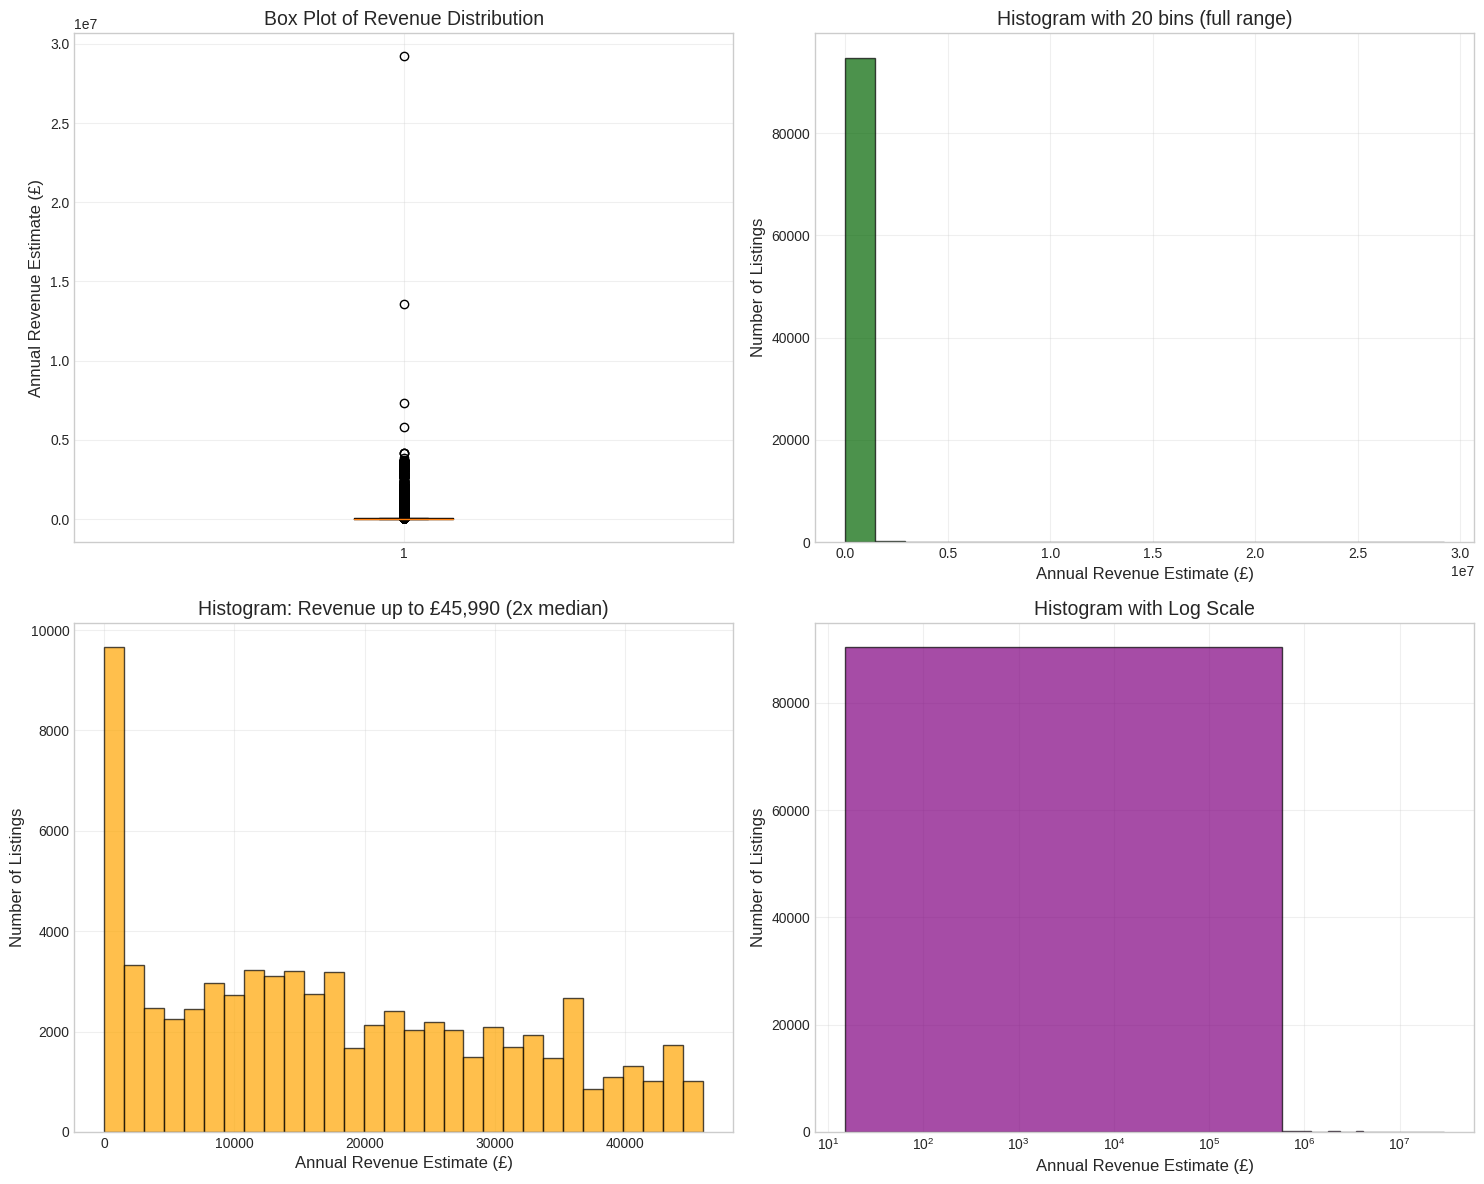


=== POTENTIAL ISSUES CHECK ===
Zero values: 4,161 (4.4%)
Most common value: £0 appears 4,161 times (4.4%)

First 5 bin ranges and counts:
Bin 1: £0 - £584,000 -> 94,496 listings
Bin 2: £584,000 - £1,168,000 -> 205 listings
Bin 3: £1,168,000 - £1,752,000 -> 81 listings
Bin 4: £1,752,000 - £2,336,000 -> 175 listings
Bin 5: £2,336,000 - £2,920,000 -> 36 listings


In [ ]:
# Alternative visualization approaches to diagnose the histogram issue
if has_reliable_data and 'annual_revenue_estimate' in reliable_listings.columns:
    revenue_data = reliable_listings['annual_revenue_estimate'].dropna()

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Box plot to see quartiles and outliers
    axes[0, 0].boxplot(revenue_data, vert=True)
    axes[0, 0].set_ylabel('Annual Revenue Estimate (£)')
    axes[0, 0].set_title('Box Plot of Revenue Distribution')
    axes[0, 0].grid(alpha=0.3)

    # 2. Histogram with fewer bins
    axes[0, 1].hist(revenue_data, bins=20, alpha=0.7, color='darkgreen', edgecolor='black')
    axes[0, 1].set_xlabel('Annual Revenue Estimate (£)')
    axes[0, 1].set_ylabel('Number of Listings')
    axes[0, 1].set_title('Histogram with 20 bins (full range)')
    axes[0, 1].grid(alpha=0.3)

    # 3. Histogram focusing on lower values (up to median * 2)
    median_val = revenue_data.median()
    low_range_data = revenue_data[revenue_data <= median_val * 2]
    axes[1, 0].hist(low_range_data, bins=30, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 0].set_xlabel('Annual Revenue Estimate (£)')
    axes[1, 0].set_ylabel('Number of Listings')
    axes[1, 0].set_title(f'Histogram: Revenue up to £{median_val * 2:,.0f} (2x median)')
    axes[1, 0].grid(alpha=0.3)

    # 4. Log scale histogram
    # Remove zeros for log scale
    log_data = revenue_data[revenue_data > 0]
    axes[1, 1].hist(log_data, bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].set_xlabel('Annual Revenue Estimate (£)')
    axes[1, 1].set_ylabel('Number of Listings')
    axes[1, 1].set_title('Histogram with Log Scale')
    axes[1, 1].set_xscale('log')
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Check for common problematic patterns
    print("\n=== POTENTIAL ISSUES CHECK ===")
    zero_count = (revenue_data == 0).sum()
    print(f"Zero values: {zero_count:,} ({zero_count/len(revenue_data)*100:.1f}%)")

    # Check if most values are the same
    most_common_value = revenue_data.mode().iloc[0] if len(revenue_data.mode()) > 0 else "N/A"
    most_common_count = (revenue_data == most_common_value).sum() if most_common_value != "N/A" else 0
    print(f"Most common value: £{most_common_value:,.0f} appears {most_common_count:,} times ({most_common_count/len(revenue_data)*100:.1f}%)")

    # Check the range of the first few bins
    hist_counts, bin_edges = np.histogram(revenue_data, bins=50)
    print(f"\nFirst 5 bin ranges and counts:")
    for i in range(5):
        print(f"Bin {i+1}: £{bin_edges[i]:,.0f} - £{bin_edges[i+1]:,.0f} -> {hist_counts[i]:,} listings")

### Revenue Distribution Analysis

Let's analyze the revenue distribution using multiple visualization approaches to understand why the histogram might appear to show only one bin.